# Sparkify Project


The aim of this project is to train a classification algorithm to predict user churning based upon information contained in user log data. More specifically, the data relates to a fictitious music streaming service called Sparkify.

In order to be able to locally run the initial analysis, I first did some basic analysis on a small subset (128 MB) of the full dataset (12 GB).

While the smaller version of the dataset is small enough to fit into the memory of a local machine, the full dataset is likely to cause issues due to its large size. Hence, in order to deal with this, it is necessary to make use of distributed computing. As the name of the fictitious streaming service "Sparkify" already implies, this project uses Spark or more specifically the Python API PySpark to deal with the large dataset. PySpark as a high-level API allows us to focus on working with the data without having to dive too deep into the principles of distributed computing.

This version of the Jupyter notebook was adapted to run on an AWS EMS cluster. Please note that the repository also contains a version of this notebook which you can run locally. 

## Structure
The project starts off with loading the data, dropping cases where there were no user IDs and a first investigation of the data.

Following this, the target variable (whether a user has churned or not) is defined and several features at the user level are created. The latter is an important point because while the original log data contains many rows for each individual user, in order to perform binary classification we will need to have only one row for each user.

These features are then compared across the two user groups, i.e. those who have churned and those who have not, to identify features which may help in predicting users' behaviour.

New components of features which have over 90% of the total variance are then created with PCA.Before the data is split into a train and a test set, numerical features are scaled using standard scaler scaling and categorical features are encoded using one-hot encoding.

The training and test datasets are then used to compare a logistic regression, random forest classifier,and a decision tree classifier. The models are evaluated using the F1 score to account for the imbalanced nature of the dataset (i.e. there are only few users who have actually churned).
  
The best model is then chosen and optimised by using hyperparameter tuning.

Finally, the results of the optimised model are briefly discussed

In [ ]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository
sc.install_pypi_package("seaborn")

In [62]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, isnan, isnull, udf, last, first, struct, lit, approx_count_distinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import when as Fwhen
from pyspark.sql.functions import lag as Flag
from pyspark.sql.functions import isnull as Fisnull
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, MinMaxScaler, VectorAssembler,StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, Evaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml import feature as FT
from pyspark.ml.tuning import ParamGridBuilder

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset

In this workspace, the mini-dataset file is mini_sparkify_event_data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [4]:
df = spark.read.json('s3n://udacity-dsnd/sparkify/sparkify_event_data.json')
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

# Exploratory Data Analysis

#### Explore Data

Let's perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. we will explore the aggregation on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [25]:
df.select('page').dropDuplicates().sort('page').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows

In [27]:
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

Checking missing values

In [28]:
nan_count = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas()
nan_count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   artist  auth  firstName  gender  ...  status  ts  userAgent  userId
0       0     0          0       0  ...       0   0          0       0

[1 rows x 18 columns]

In [29]:
null_count = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()
null_count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    artist  auth  firstName  gender  ...  status  ts  userAgent  userId
0  5408927     0     778479  778479  ...       0   0     778479       0

[1 rows x 18 columns]

In [41]:
df.where(col('artist').isNotNull()).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+---------+------+-------------+---------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|              artist|     auth|firstName|gender|itemInSession| lastName|    length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+--------------------+---------+---------+------+-------------+---------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|           Popol Vuh|Logged In|    Shlok|     M|          278|  Johnson| 524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|         Los Bunkers|Logged In|  Vianney|     F|            9|   Miller| 238.39302| paid|San Francisco-Oak.

In [32]:
df.where(col('firstName').isNull()).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       artist        auth firstName  ...             ts  userAgent   userId
0        None  Logged Out      None  ...  1538352008000       None  1261737
1        None  Logged Out      None  ...  1538352041000       None  1261737
2        None  Logged Out      None  ...  1538352182000       None  1261737
3        None  Logged Out      None  ...  1538352254000       None  1261737
4        None  Logged Out      None  ...  1538352255000       None  1261737
...       ...         ...       ...  ...            ...        ...      ...
778474   None  Logged Out      None  ...  1543621929000       None  1261737
778475   None  Logged Out      None  ...  1543622063000       None  1261737
778476   None  Logged Out      None  ...  1543622064000       None  1261737
778477   None  Logged Out      None  ...  1543622165000       None  1261737
778478   None  Logged Out      None  ...  1543622166000       None  1261737

[778479 rows x 18 columns]

In [33]:
df.where(col('userId').isNull()).groupBy('registration', 'auth').count().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  registration        auth   count
0         None  Logged Out  774285
1         None       Guest    4194

Since logs with empty/missing userId can’t help us identify the users, we can’t make predictions for them. So we drop them from our analysis.

In [13]:
df = df.where(col('userId').isNotNull())
df = df.where(col('gender').isNotNull())
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

25480720

# Define Churn

Before we can move on to comparing users who churned and those who did not, we first need to think about what we would define as churne. A narrow definition would probably only include people who have deleted their account， which is captured in our data as cases where the page feature takes on the value "Cancellation Confirmation".

If we take on a broader view, we could also think of users downgrading their services from paid to free as a type of churning. It turns out that identifying these users is a bit more complicated. While a user can only cancel their registration once, it is very much possible for a customer to downgrade from the paid to the free service and to then upgrade to the paid service again or to even repeat this cycle.

The question then is whether these two kinds of churning should be regarded as identical or whether we should really think of this as a multiclass-classification problem instead of a binary classification problem. Ideally, we should conduct a survey with users who canceled their registration and those who only switched from the paid to the free version of the service to gain some insights as to whether they are similar or quite different. This is unfortunately not possible for this project.

Looking at the available data, it turns out that if we also include users who just downgraded their accounts from paid to free, but still kept using the service many differences between the two groups of users become much less clear cut. Therefore, I decided to only include users who canceled their services here.

Finally, strictly speaking defining churn by just accounting for users who have canceled their account will quite likely underestimate actual churn rates. There may be users who perhaps never used the paid service and who stopped using the service, but never bothered to cancel their registration. Given that the data we have here only covers about two months, it is probably not reasonable to try to cover this problem, but it is certainly a point worth keeping in mind.

We will use the Cancellation Confirmation event of pages to define churn. Churned users will have a 1 in the column churn, the label column for our model.

In [14]:
user_log = df

flag_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log = user_log.withColumn('cancel_page',flag_churn('page'))

windowval = Window.partitionBy('userId')

user_log = user_log.withColumn('churned',Fsum('cancel_page').over(windowval))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
print('Number of users who have churned {}'.\
      format(user_log.filter(user_log.churned == 1).select('userId').dropDuplicates().count()))
print('Number of users who have not churned {}'.\
      format(user_log.filter(user_log.churned == 0).select('userId').dropDuplicates().count()))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of users who have churned 5003
Number of users who have not churned 17275

In [53]:
#percent of churned users
user_log.filter(user_log['churned']==1).select('userId').distinct().count()/user_log.select('userId')\
        .distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.22457132597181076

We can see that the two labels (churn and non-churn) of the dataset are inbalanced.

#### Gender Distribution

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

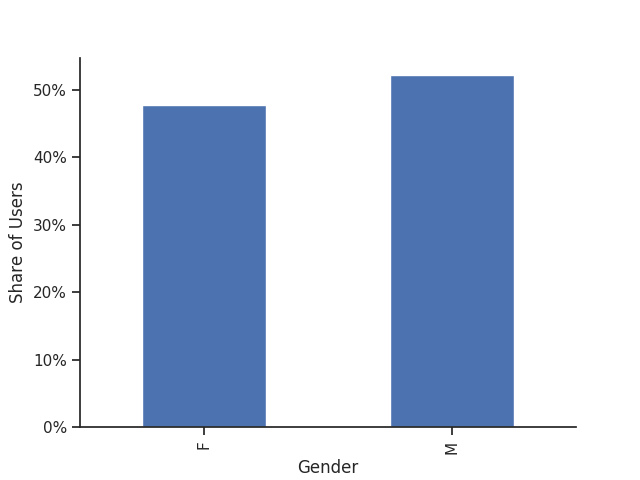

In [16]:
# Look at gender distribution by user, i.e. how many users identified as male, female or did not provide an answer?
num_obs = user_log.count()
gender_user_df = user_log.groupBy('gender').count().toPandas()
gender_user_df['count'] = gender_user_df['count']/num_obs
gender_user_df.plot.bar(x = 'gender', color = sns.color_palette()[0], legend = None)
sns.set(style="ticks")
sns.despine(right=True,top=True)
plt.xlabel('Gender')
plt.ylabel('Share of Users')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()
# Magic command to display plot
%matplot plt

In [23]:

level_churn_df = user_log.groupBy('level').count().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Level Distribution

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

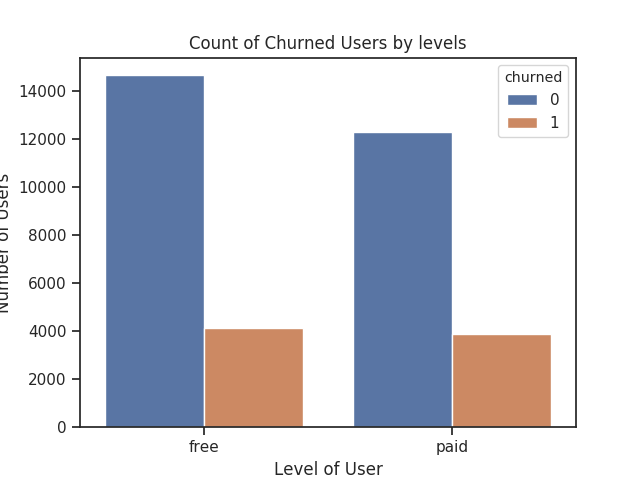

In [24]:
# Visualising churn counts by level of Users
level_churn_df = user_log.select('userId','level','churned').dropDuplicates().toPandas()
sns.countplot(x='level',hue='churned',data=level_churn_df)
plt.xlabel("Level of User")
plt.ylabel("Number of Users")
plt.title("Count of Churned Users by levels")
# Magic command to display plot
%matplot plt



In [58]:
free_churned = len(level_churn_df[(level_churn_df['churned'] == 1) & (level_churn_df['level'] == 'free')]) / len(level_churn_df[level_churn_df['level'] == 'free']) * 100
paid_churned = len(level_churn_df[(level_churn_df['churned'] == 1) & (level_churn_df['level'] == 'paid')])/ len(level_churn_df[level_churn_df['level'] == 'paid']) * 100

print("there were %d percent free users churned" % free_churned)
print("there were %d percent paid users churned" % paid_churned)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

there were 22 percent free users churned
there were 24 percent paid users churned

In [27]:
# pivot table displaying number of page events per user
df_page = user_log.groupby("userId","churned").pivot("page").count().fillna(0).toPandas()
df_page.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    userId  churned  About  ...  Thumbs Down  Thumbs Up  Upgrade
0  1000280        1      0  ...           33         53        9
1  1002185        0      1  ...           14         92        0
2  1017805        0      1  ...            4          7        0
3  1030587        0      1  ...           16         66        1
4  1033297        0      2  ...            3         10        2

[5 rows x 21 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

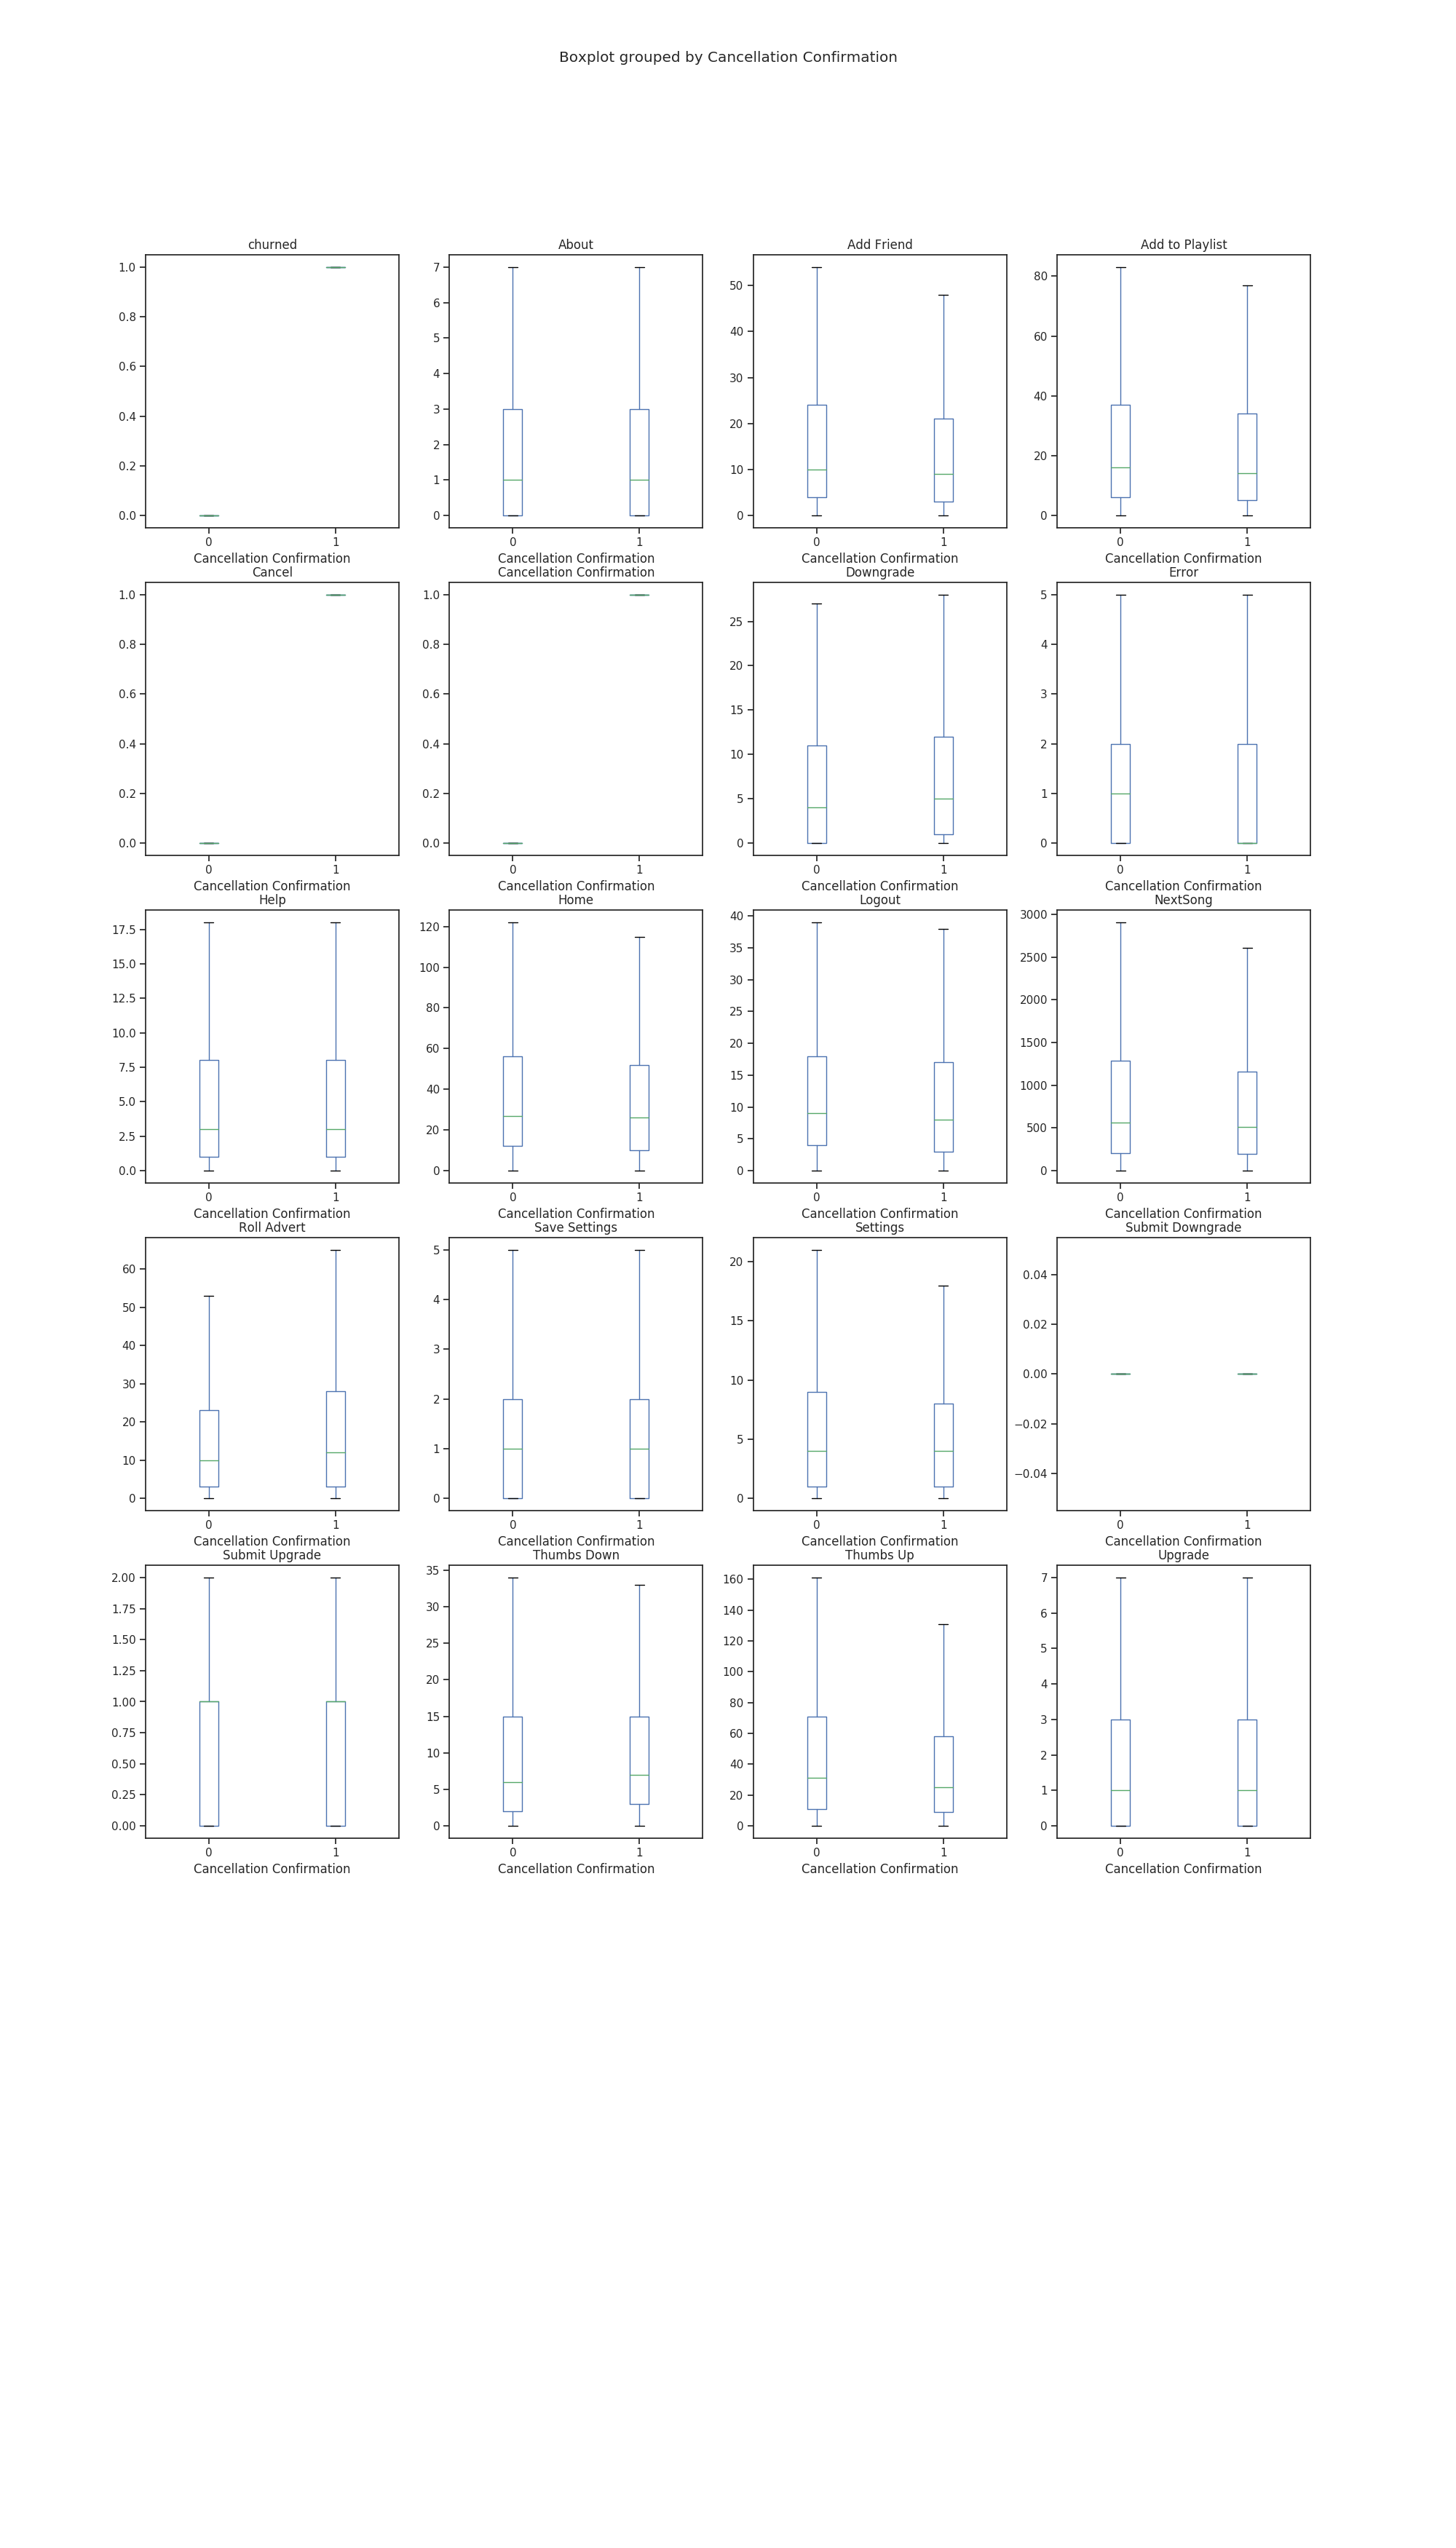

In [47]:
# Boxplot grouped by Cancellation Confirmation
fig= plt.figure(figsize = (20, 35))

for i in range(1,21):
    ax = fig.add_subplot(6, 4, i)
    df_page.boxplot(df_page.columns[i].format(), ax=ax,  by='Cancellation Confirmation', grid=False, showfliers=False)
# Magic command to display plot
%matplot plt

In [61]:
#Time spent by users of both groups listening to songs
user_log.where(user_log["page"] == "NextSong").select("userId","churned","length")\
                        .groupby("userId","churned").agg({"length":"sum"})\
                        .groupby("churned")\
                        .agg({"sum(length)":"avg"})\
                        .withColumnRenamed("avg(sum(length))", "Average_time").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churned   Average_time
0        0  237279.893188
1        1  218068.623383

In [62]:
# number of thumbs up
user_log.select("userId", "page","churned").where(user_log["page"]=="Thumbs Up")\
                .groupby("userId","churned").agg({"page":"count"}) \
                .groupby("churned")\
                .agg({"count(page)":"avg"})\
                .withColumnRenamed("avg(count(page))","Average_num_Thumbs_up").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churned  Average_num_Thumbs_up
0        0              54.884133
1        1              46.359356

In [63]:
# number of thumbs down
user_log.select("userId", "page","churned").where(user_log["page"]=="Thumbs Down")\
                .groupby("userId","churned").agg({"page":"count"}) \
                .groupby("churned")\
                .agg({"count(page)":"avg"})\
                .withColumnRenamed("avg(count(page))", "Average_num_Thumbs_down").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churned  Average_num_Thumbs_down
0        0                11.869891
1        1                12.186556

In [64]:
# number of songs played
user_log.select("userId","song","churned")\
                .groupby("userId","churned").agg({"song":"count"})\
                .groupby("churned")\
                .agg({"count(song)":"avg"})\
                .withColumnRenamed("avg(count(song))", "average_num_songs").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churned  average_num_songs
0        0         953.053314
1        1         876.729163

In [65]:
# Number of songs listened per session per user
user_log.filter(user_log["page"]=="NextSong")\
                .groupby("userId","sessionId").agg({"sessionId":"count"})\
                .groupby("userId")\
                .agg({"count(sessionId)":"avg"})\
                .withColumnRenamed("avg(count(sessionId))","songsPerSession").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        userId  songsPerSession
0      1690101        66.166667
1      1994878        77.185185
2      1396135       121.750000
3      1875484        59.960000
4      1057724        98.641026
...        ...              ...
22256  1667533        41.000000
22257  1684049         7.000000
22258  1684976        56.000000
22259  1522729         8.000000
22260  1315297         6.000000

[22261 rows x 2 columns]

In [66]:
# number of days since registration
user_log.select("userId","churned","registration","ts")\
                .withColumn("timeSinceReg", (user_log["ts"]-user_log["registration"]))\
                .groupby("userId", "churned")\
                .agg({"timeSinceReg": "max"})\
                .withColumnRenamed("max(timeSinceReg)","active_days")\
                .select("userId","churned",(col("active_days")/1000/3600/24).alias("active_days"))\
                .groupby("churned")\
                .agg({"active_days":"avg"}).withColumnRenamed("avg(active_days)", "avg_num_of_active_days").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churned  avg_num_of_active_days
0        0               89.085637
1        1               63.718817

In [67]:
# number of added friends
user_log.select("userId", "page","churned")\
        .where(user_log["page"]=="Add Friend")\
        .groupby("userId","churned")\
        .agg({"page": "count"})\
        .groupby("churned")\
        .agg({"count(page)":"avg"}).withColumnRenamed("avg(count(page))", "avg_num_of_added_friends")\
        .toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churned  avg_num_of_added_friends
0        0                 19.099278
1        1                 17.736644

# Feature Engineering

Now we are familiarized with the data, let's build the features we find promising to train the model on.

In [29]:
user_log = user_log.withColumn('last_level', F.last('level').over(windowval))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
f1 = user_log.select("userId", "length").groupby("userId").agg({"length":"sum"}).withColumnRenamed("sum(length)","playTime")
f1.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
| userId|          playTime|
+-------+------------------+
|1331962|148756.85789999997|
|1178731| 660566.6424100002|
|1528396| 35037.27158999999|
|1002185| 443147.6018400002|
|1333041|175032.77991999994|
|1567623|      289641.02011|
|1190352| 557463.9422099999|
|1983423|      347589.28267|
|1271218|     1181907.07069|
|1396828|317196.14491000003|
|1142513|123071.83463000003|
|1875484|      378543.56859|
|1083324|       365434.7555|
|1612069|65158.778920000004|
|1734557|115957.86127000001|
|1071308|      352855.68121|
|1492713|113752.08030000003|
|1658815|      264968.08471|
|1057724| 956838.1185800001|
|1718034|179379.63190000004|
+-------+------------------+
only showing top 20 rows

In [31]:
f2 = user_log.select("userId","song")\
                .groupby("userId").agg({"song":"count"}).withColumnRenamed("count(song)", "numSongs")
f2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------+
| userId|numSongs|
+-------+--------+
|1331962|     607|
|1178731|    2663|
|1528396|     141|
|1002185|    1778|
|1333041|     714|
|1567623|    1135|
|1190352|    2216|
|1983423|    1370|
|1271218|    4779|
|1396828|    1272|
|1142513|     480|
|1875484|    1499|
|1083324|    1484|
|1612069|     259|
|1734557|     468|
|1071308|    1409|
|1492713|     471|
|1658815|    1066|
|1057724|    3847|
|1718034|     718|
+-------+--------+
only showing top 20 rows

In [32]:
f3 = user_log.select("userId","artist")\
                .groupby("userId").agg(F.countDistinct("artist")).withColumnRenamed("count(DISTINCT artist)", "numArtist")
f3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+
| userId|numArtist|
+-------+---------+
|1083324|     1061|
|1178731|     1684|
|1114507|      656|
|1338783|     1162|
|1875484|     1081|
|1002185|     1205|
|1200956|     1994|
|1994878|     1379|
|1567623|      866|
|1394508|      871|
|1718034|      589|
|1794110|      480|
|1190352|     1434|
|1071308|     1007|
|1492713|      381|
|1792192|      856|
|1588738|     1320|
|1917123|      300|
|1663036|      909|
|1271218|     2535|
+-------+---------+
only showing top 20 rows

In [33]:
f4 = user_log.select("userId","registration","ts")\
                .withColumn("timeSinceReg", (user_log["ts"]-user_log["registration"]))\
                .groupby("userId")\
                .agg({"timeSinceReg": "max"})\
                .withColumnRenamed("max(timeSinceReg)","active_days")\
                .select("userId",(col("active_days")/1000/3600/24).alias("active_days"))
f4.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
| userId|       active_days|
+-------+------------------+
|1390009| 35.85293981481481|
|1519090|  64.2630787037037|
|1394508|  92.1307638888889|
|1178731| 93.45488425925926|
|1351489| 74.14202546296296|
|1358765|         93.405625|
|1500901| 83.96828703703703|
|1718034|45.504803240740735|
|1384823|54.353240740740745|
|1083324|148.55572916666668|
|1633577|132.62342592592594|
|1875484|43.823113425925925|
|1492713|127.13427083333333|
|1658815| 66.36427083333334|
|1114507|  99.9158101851852|
|1331962| 71.69137731481482|
|1588738|118.99291666666666|
|1338783| 60.96709490740741|
|1965481|  74.6517361111111|
|1057724| 96.04454861111111|
+-------+------------------+
only showing top 20 rows

In [34]:
f5 = user_log.select("userId","sessionId")\
                .groupby("userId").agg(F.countDistinct("sessionId")).withColumnRenamed("count(DISTINCT sessionId)", "numSession")
f5.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+
| userId|numSession|
+-------+----------+
|1338783|        16|
|1271218|        51|
|1492713|        17|
|1875484|        25|
|1624220|        16|
|1829495|         5|
|1770964|        16|
|1380035|        27|
|1633577|        46|
|1797408|        16|
|1394508|        29|
|1796854|         3|
|1994878|        29|
|1619792|        14|
|1452122|        21|
|1200956|        44|
|1180406|         9|
|1178731|        23|
|1983423|        15|
|1500901|        29|
+-------+----------+
only showing top 20 rows

In [35]:
#encode level and gender
indexer = StringIndexer(inputCol="last_level", outputCol="encoded_level")
user_log = indexer.fit(user_log).transform(user_log)

indexer1 = StringIndexer(inputCol="gender", outputCol="encoded_gender")
user_log = indexer1.fit(user_log).transform(user_log)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
user_features = user_log.select("userId", "encoded_level", "encoded_gender").dropDuplicates()

f6 = user_features.select("userId","encoded_level")\
        .groupby("userId")\
        .agg({"encoded_level": "max"}).withColumnRenamed("max(encoded_level)", "encoded_level")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
f7 = user_features.select("userId","encoded_gender")\
        .groupby("userId")\
        .agg({"encoded_gender": "max"}).withColumnRenamed("max(encoded_gender)", "encoded_gender")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
user_df = user_log.groupby('userId').agg(
    # User-level features
    F.max('churned').alias('churn'),

    # interaction-level features (exclude Cancellation Confirmation)
    F.count('page').alias('n_act'),
    F.sum(F.when(F.col('page')=='About', 1).otherwise(0)).alias('n_about'),
    F.sum(F.when(F.col('page')=='Add Friend', 1).otherwise(0)).alias('n_addFriend'),
    F.sum(F.when(F.col('page')=='Add to Playlist', 1).otherwise(0)).alias('n_addToPlaylist'),
    F.sum(F.when(F.col('page')=='Cancel', 1).otherwise(0)).alias('n_cancel'),
    F.sum(F.when(F.col('page')=='Downgrade', 1).otherwise(0)).alias('n_downgrade'),
    F.sum(F.when(F.col('page')=='Error', 1).otherwise(0)).alias('n_error'),
    F.sum(F.when(F.col('page')=='Help', 1).otherwise(0)).alias('n_help'),
    F.sum(F.when(F.col('page')=='Home', 1).otherwise(0)).alias('n_home'),
    F.sum(F.when(F.col('page')=='Logout', 1).otherwise(0)).alias('n_logout'),
    F.sum(F.when(F.col('page')=='Roll Advert', 1).otherwise(0)).alias('n_rollAdvert'),
    F.sum(F.when(F.col('page')=='Save Settings', 1).otherwise(0)).alias('n_saveSettings'),
    F.sum(F.when(F.col('page')=='Settings', 1).otherwise(0)).alias('n_settings'),
    F.sum(F.when(F.col('page')=='Submit Downgrade', 1).otherwise(0)).alias('n_submitDowngrade'),
    F.sum(F.when(F.col('page')=='Submit Upgrade', 1).otherwise(0)).alias('n_submitUpgrade'),
    F.sum(F.when(F.col('page')=='Thumbs Down', 1).otherwise(0)).alias('n_thumbsDown'),
    F.sum(F.when(F.col('page')=='Thumbs Up', 1).otherwise(0)).alias('n_thumbsUp'),
    F.sum(F.when(F.col('page')=='Upgrade', 1).otherwise(0)).alias('n_upgrade'),

)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
user_df = user_df.join(f1, on = "userId")\
           .join(f2, on = "userId")\
           .join(f3, on = "userId")\
           .join(f4, on = "userId")\
           .join(f5, on = "userId")\
           .join(f6, on = "userId")\
           .join(f7, on = "userId")
            
user_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+-----+-------+-----------+---------------+--------+-----------+-------+------+------+--------+------------+--------------+----------+-----------------+---------------+------------+----------+---------+------------------+--------+---------+------------------+----------+-------------+--------------+
| userId|churn|n_act|n_about|n_addFriend|n_addToPlaylist|n_cancel|n_downgrade|n_error|n_help|n_home|n_logout|n_rollAdvert|n_saveSettings|n_settings|n_submitDowngrade|n_submitUpgrade|n_thumbsDown|n_thumbsUp|n_upgrade|          playTime|numSongs|numArtist|       active_days|numSession|encoded_level|encoded_gender|
+-------+-----+-----+-------+-----------+---------------+--------+-----------+-------+------+------+--------+------------+--------------+----------+-----------------+---------------+------------+----------+---------+------------------+--------+---------+------------------+----------+-------------+--------------+
|1000280|    1| 1317|      0|         14|             25| 

In [124]:
user_df.persist();
user_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- n_act: long (nullable = false)
 |-- n_about: long (nullable = true)
 |-- n_addFriend: long (nullable = true)
 |-- n_addToPlaylist: long (nullable = true)
 |-- n_cancel: long (nullable = true)
 |-- n_downgrade: long (nullable = true)
 |-- n_error: long (nullable = true)
 |-- n_help: long (nullable = true)
 |-- n_home: long (nullable = true)
 |-- n_logout: long (nullable = true)
 |-- n_rollAdvert: long (nullable = true)
 |-- n_saveSettings: long (nullable = true)
 |-- n_settings: long (nullable = true)
 |-- n_submitDowngrade: long (nullable = true)
 |-- n_submitUpgrade: long (nullable = true)
 |-- n_thumbsDown: long (nullable = true)
 |-- n_thumbsUp: long (nullable = true)
 |-- n_upgrade: long (nullable = true)
 |-- playTime: double (nullable = true)
 |-- numSongs: long (nullable = false)
 |-- numArtist: long (nullable = false)
 |-- active_days: double (nullable = true)
 |-- numSession: long (nullable = fa

#### Correlations among Features

Multicollinearity increases the standard errors of the coefficients. Increased standard errors in turn means that coefficients for some independent variables may be found not to be significantly different from 0. In other words, by overinflating the standard errors, multicollinearity makes some variables statistically insignificant when they should be significant. Without multicollinearity (and thus, with lower standard errors), those coefficients might be significant.

In [168]:
user_pd = user_df.dropna().toPandas()
user_pd.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(22261, 27)

In [175]:
# a funciton to plot correlations among columns
def plot_corr(cols, figsize=(10,10), df=user_pd):
    plt.figure(figsize=figsize)
    sns.heatmap(df[cols].corr(),
                square=True, cmap='YlGnBu', annot=True,
                vmin=-1, vmax=1)
    plt.ylim(len(cols), 0)
    plt.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

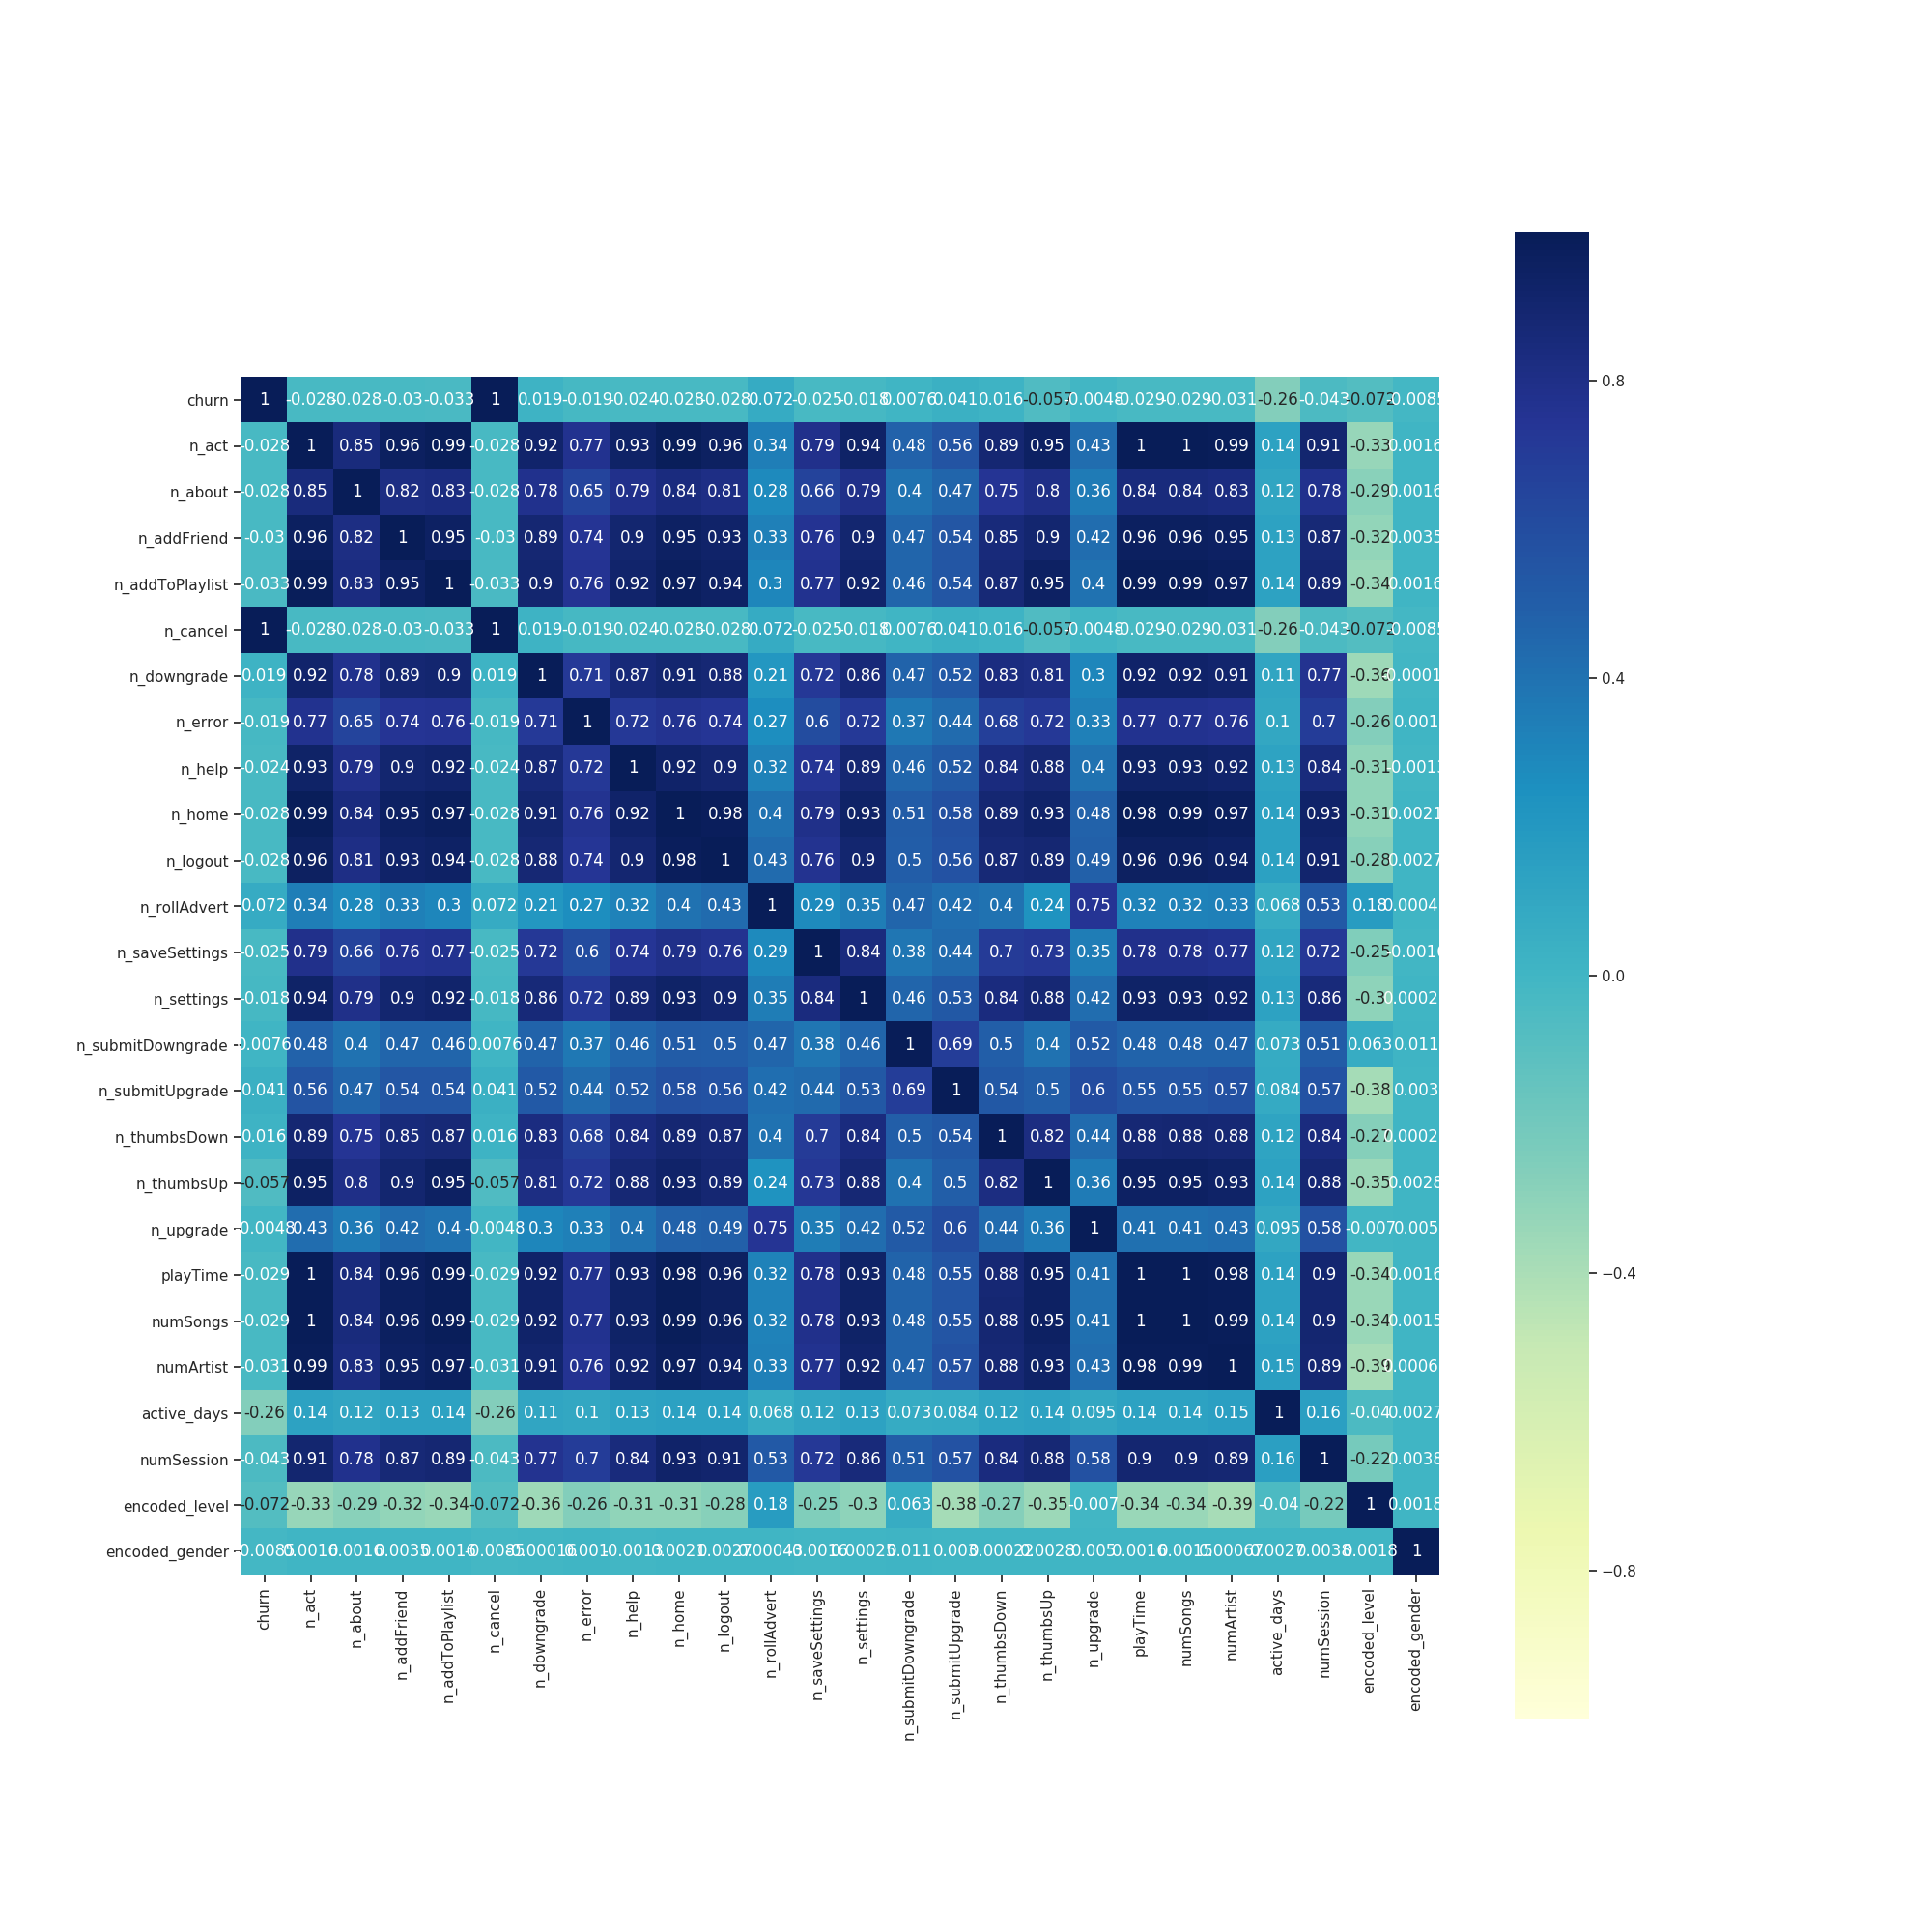

In [176]:

# correlations between features
numerical_cols = user_pd.select_dtypes(include=np.number).columns.tolist()
plot_corr(numerical_cols, figsize=(20,20))
# Magic command to display plot
%matplot plt

We can see that there are some variable pairs with correlation coefficient over 0.8, which means that many of our variables are highly corelated. in order to remove the multicollinearity, let's try a few approaches:

- Remove correlated features manually

- PCA

#### 1. Remove correlated features manually

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

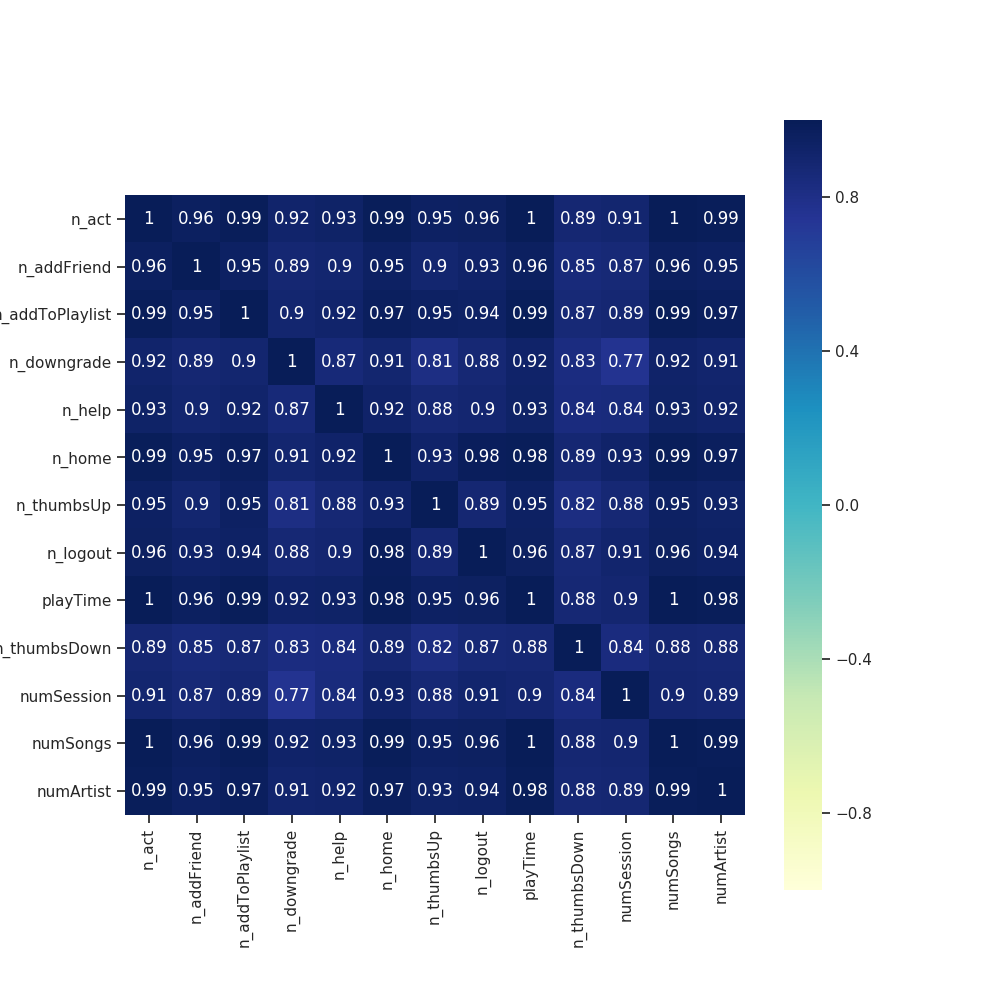

In [179]:
cols = ['n_act', 'n_addFriend', 'n_addToPlaylist', 'n_downgrade',
        'n_help', 'n_home', 'n_thumbsUp','n_logout','playTime', 'n_thumbsDown', 'numSession','numSongs',
        'numArtist']
plot_corr(cols)
# Magic command to display plot
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

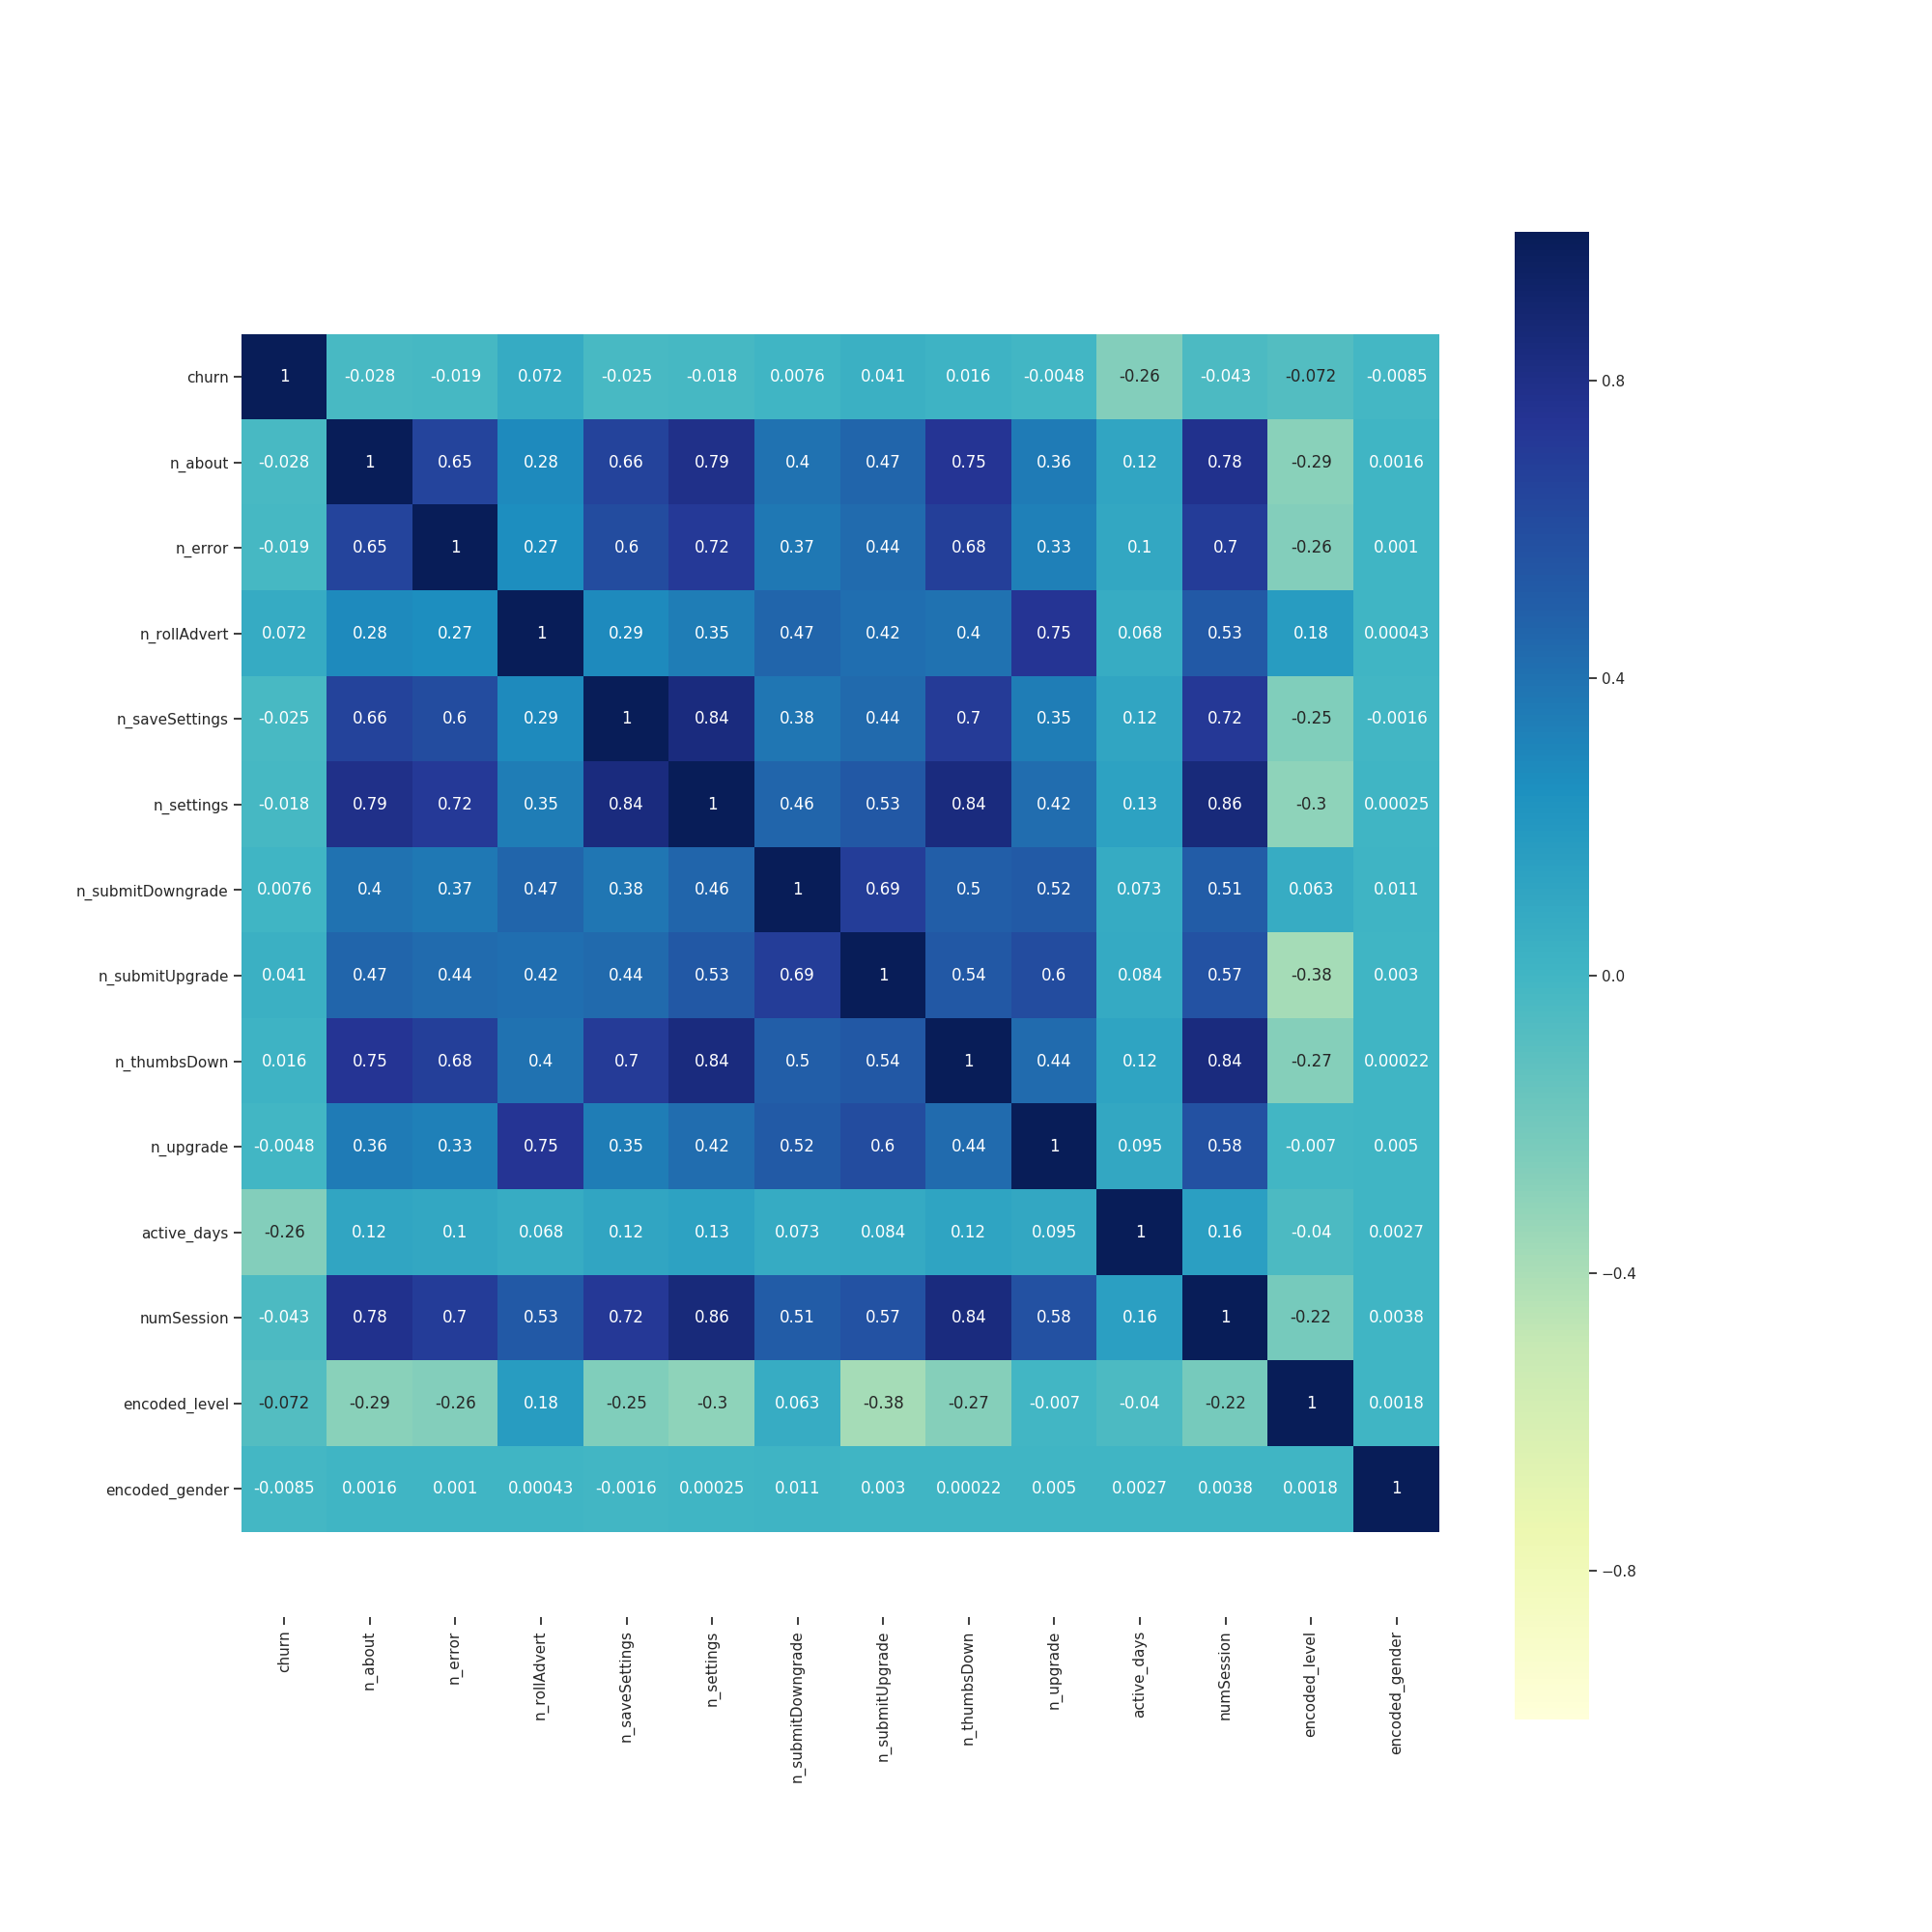

In [181]:
# correlations between numerical features after removing highly correlated columns
drop_cols = ['n_act', 'n_addFriend', 'n_addToPlaylist', 'n_downgrade',
        'n_help', 'n_home', 'n_thumbsUp','n_logout', 'playTime', 'n_cancel','numSongs','numArtist']
numerical_cols1 = [col for col in user_pd.columns if col not in drop_cols]
plot_corr(numerical_cols1, figsize=(20,20))
# Magic command to display plot
%matplot plt

In [182]:
user_df_m = user_df.select(*numerical_cols1).withColumnRenamed('churned', 'label')
user_df_m.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- n_about: long (nullable = true)
 |-- n_error: long (nullable = true)
 |-- n_rollAdvert: long (nullable = true)
 |-- n_saveSettings: long (nullable = true)
 |-- n_settings: long (nullable = true)
 |-- n_submitDowngrade: long (nullable = true)
 |-- n_submitUpgrade: long (nullable = true)
 |-- n_thumbsDown: long (nullable = true)
 |-- n_upgrade: long (nullable = true)
 |-- active_days: double (nullable = true)
 |-- numSession: long (nullable = false)
 |-- encoded_level: double (nullable = true)
 |-- encoded_gender: double (nullable = true)

In [ ]:
# Vector Assembler
cols = user_df_m.drop('userId','churn').columns
assembler = VectorAssembler(inputCols=cols, outputCol='Features')
user_df_m = assembler.transform(user_df_m)

In [ ]:
# Standard Scaler
scaler= FT.StandardScaler(inputCol='Features', outputCol='scaled_features_1', withStd=True)
scalerModel = scaler.fit(user_df_m)
user_df_m = scalerModel.transform(user_df_m)

In [187]:
user_df_m.persist();
user_df_m.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- n_about: long (nullable = true)
 |-- n_error: long (nullable = true)
 |-- n_rollAdvert: long (nullable = true)
 |-- n_saveSettings: long (nullable = true)
 |-- n_settings: long (nullable = true)
 |-- n_submitDowngrade: long (nullable = true)
 |-- n_submitUpgrade: long (nullable = true)
 |-- n_thumbsDown: long (nullable = true)
 |-- n_upgrade: long (nullable = true)
 |-- active_days: double (nullable = true)
 |-- numSession: long (nullable = false)
 |-- encoded_level: double (nullable = true)
 |-- encoded_gender: double (nullable = true)
 |-- Features: vector (nullable = true)
 |-- scaled_features_1: vector (nullable = true)

In [188]:
# selecting the two required columns for modelling
m_features_df = user_df_m.select(col('scaled_features_1').alias('features'), col('churn').alias('label'))
m_features_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[features: vector, label: bigint]

#### 2. PCA

Principal component analysis (PCA) is a statistical analysis technique that transforms possibly correlated variables to orthogonal linearly uncorrelated values. We can use it for applications such as data compression, to get dominant physical processes and to get important features for machine learning. Without losing much information, it reduces the number of features in the original data.

In [125]:
# Vector Assembler
user_df_pca = user_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [126]:
user_df_pca.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- n_act: long (nullable = false)
 |-- n_about: long (nullable = true)
 |-- n_addFriend: long (nullable = true)
 |-- n_addToPlaylist: long (nullable = true)
 |-- n_cancel: long (nullable = true)
 |-- n_downgrade: long (nullable = true)
 |-- n_error: long (nullable = true)
 |-- n_help: long (nullable = true)
 |-- n_home: long (nullable = true)
 |-- n_logout: long (nullable = true)
 |-- n_rollAdvert: long (nullable = true)
 |-- n_saveSettings: long (nullable = true)
 |-- n_settings: long (nullable = true)
 |-- n_submitDowngrade: long (nullable = true)
 |-- n_submitUpgrade: long (nullable = true)
 |-- n_thumbsDown: long (nullable = true)
 |-- n_thumbsUp: long (nullable = true)
 |-- n_upgrade: long (nullable = true)
 |-- playTime: double (nullable = true)
 |-- numSongs: long (nullable = false)
 |-- numArtist: long (nullable = false)
 |-- active_days: double (nullable = true)
 |-- numSession: long (nullable = fa

In [132]:
user_df_pca = user_df_pca.dropna()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [133]:
# Vector Assembler
cols = user_df_pca.drop('userId','churn').columns
assembler = VectorAssembler(inputCols=cols, outputCol='Features')
user_df_pca = assembler.transform(user_df_pca)

# Standard Scaler
scaler= FT.StandardScaler(inputCol='Features', outputCol='scaled_features_1', withStd=True)
scalerModel = scaler.fit(user_df_pca)
user_df_pca = scalerModel.transform(user_df_pca)
user_df_pca.head()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(userId='1000280', churn=1, n_act=1317, n_about=0, n_addFriend=14, n_addToPlaylist=25, n_cancel=1, n_downgrade=3, n_error=3, n_help=8, n_home=44, n_logout=15, n_rollAdvert=74, n_saveSettings=1, n_settings=9, n_submitDowngrade=1, n_submitUpgrade=1, n_thumbsDown=33, n_thumbsUp=53, n_upgrade=9, playTime=259349.89726000009, numSongs=1022, numArtist=767, active_days=77.30377314814815, numSession=22, encoded_level=1.0, encoded_gender=0.0, Features=DenseVector([1317.0, 0.0, 14.0, 25.0, 1.0, 3.0, 3.0, 8.0, 44.0, 15.0, 74.0, 1.0, 9.0, 1.0, 1.0, 33.0, 53.0, 9.0, 259349.8973, 1022.0, 767.0, 77.3038, 22.0, 1.0, 0.0]), scaled_features_1=DenseVector([0.9967, 0.0, 0.6824, 0.7794, 2.3958, 0.2586, 1.8038, 1.1188, 0.9581, 1.0309, 3.5851, 0.5305, 1.1438, 1.6501, 1.3223, 2.6155, 0.8205, 3.3921, 0.9481, 0.9293, 1.2736, 1.8909, 1.6887, 2.0388, 0.0]))

In [136]:
#Apply PCA
pca = PCA(k=7, inputCol = scaler.getOutputCol(), outputCol="pcaFeatures")
pca = pca.fit(user_df_pca)

pca_result = pca.transform(user_df_pca).select("userId","churn","pcaFeatures")
pca_result.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+----------------------------------------------------------------------------------------------------------------------------------------------+
|userId |churn|pcaFeatures                                                                                                                                   |
+-------+-----+----------------------------------------------------------------------------------------------------------------------------------------------+
|1000280|1    |[-5.186279924678222,-4.975811910187247,0.15366435707517972,-0.9573912288363066,0.15632518563292416,3.017193149682967,-0.44958436945163105]    |
|1002185|0    |[-5.51131095996423,1.1291866895777964,-1.1892388915729282,0.08395942527170269,1.9981017234251586,1.2361910787174655,-0.349360470811368]       |
|1017805|0    |[-1.2919003073099196,0.047374431976915585,-0.9173553636870608,0.703995991973877,1.8264984828370203,1.006527469018925,-0.2632056760694891]     |
|1030587|0    |[-5.346605499471486,0.467541188

In [138]:
# The variance explained
np.round(100.00*pca.explainedVariance.toArray(),7)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([64.1707234,  7.8361737,  5.0938737,  4.0369512,  3.9968888,
        2.9602885,  2.6178424])

For keeping 90% of variance, I decided to have 7 components.

In [139]:
pcs = np.round(pca.pc.toArray(),10)
pcs

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[-2.47389482e-01,  6.42743260e-02, -3.92693490e-03,
        -4.22565299e-02,  1.30431621e-02,  1.71321000e-04,
        -4.13457720e-03],
       [-2.13025085e-01,  6.66647025e-02, -6.93811440e-03,
        -5.21338712e-02,  1.64521085e-02, -3.41223310e-03,
         1.18403408e-02],
       [-2.39413809e-01,  5.72375947e-02, -5.77287020e-03,
        -4.27768331e-02,  1.51807929e-02, -2.20823640e-03,
         4.92617070e-03],
       [-2.43428744e-01,  8.57905734e-02, -6.26149090e-03,
        -3.69079598e-02,  1.19706828e-02, -5.48788220e-03,
        -6.82040580e-03],
       [ 5.81860150e-03, -4.90220733e-02,  7.13533172e-01,
        -6.47621639e-02,  2.53628930e-02,  6.24222121e-01,
        -2.71820233e-01],
       [-2.27491990e-01,  1.24257022e-01,  5.18534156e-02,
         5.25666360e-03,  1.97986430e-03, -3.76703528e-02,
        -1.89780739e-01],
       [-1.95317558e-01,  5.82515130e-02,  4.39417200e-03,
        -4.85286140e-02,  1.51673539e-02, -9.43078050e-03,
         1.6341685

In [145]:
col_pca = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7']
df_pc = pd.DataFrame(pcs, columns = col_pca, index = cols)
df_pc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                        PC1       PC2       PC3  ...       PC5       PC6       PC7
n_act             -0.247389  0.064274 -0.003927  ...  0.013043  0.000171 -0.004135
n_about           -0.213025  0.066665 -0.006938  ...  0.016452 -0.003412  0.011840
n_addFriend       -0.239414  0.057238 -0.005773  ...  0.015181 -0.002208  0.004926
n_addToPlaylist   -0.243429  0.085791 -0.006261  ...  0.011971 -0.005488 -0.006820
n_cancel           0.005819 -0.049022  0.713533  ...  0.025363  0.624222 -0.271820
n_downgrade       -0.227492  0.124257  0.051853  ...  0.001980 -0.037670 -0.189781
n_error           -0.195318  0.058252  0.004394  ...  0.015167 -0.009431  0.001634
n_help            -0.233343  0.060433 -0.002265  ...  0.012506  0.002293 -0.009552
n_home            -0.247132  0.012481 -0.009282  ...  0.012653  0.007269  0.013824
n_logout          -0.241255 -0.012394 -0.015456  ...  0.018082  0.023253  0.038938
n_rollAdvert      -0.101747 -0.556125 -0.003163  ...  0.022534  0.214213  0.336759
n_sa

In [146]:
pca_result.persist();
pca_result.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- pcaFeatures: vector (nullable = true)

In [147]:
# selecting the two required columns for modelling
pca_features_df = pca_result.select(col('pcaFeatures').alias('features'), col('churn').alias('label'))
pca_features_df

pca_features_df.persist();
pca_features_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)

In [148]:
pca_features_df.limit(2).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                            features  label
0  [-5.186279924678222, -4.975811910187247, 0.153...      1
1  [-5.51131095996423, 1.1291866895777964, -1.189...      0

# Modeling

#### Split Data into Train and Test sets

From the distribution of churn shown in the previous session, we know that this is an unbalanced dataset with only 1/4 of users labeled as churn. To avoid unbalanced results in random split, we first make a train set with sampling by label, then subtract them from the whole dataset to get the test set.

In [189]:
# prepare training and test data, sample by label
ratio = 0.7
train_pca = pca_features_df.sampleBy('churn', fractions={0:ratio, 1:ratio}, seed=123)
test_pca = pca_features_df.subtract(train_pca)
train_m = m_features_df.sampleBy('churn', fractions={0:ratio, 1:ratio}, seed=123)
test_m = m_features_df.subtract(train_m)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Model Selection
In order to select a good model for the final tuning, we will compare four different classifier models in Spark's ML:

- Logistic Regression 
- Decision Tree
- Random Forest

##### Logistic Regression 

In [150]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# evaluator
evaluator_1 = MulticlassClassificationEvaluator(metricName='f1')

# paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=evaluator_1, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [190]:
cvModel_lr_pca = crossval_lr.fit(train_pca)
cvModel_lr_m = crossval_lr.fit(train_m)
print(cvModel_lr_pca.avgMetrics)
print(cvModel_lr_m.avgMetrics)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[1.0]
[0.7468688352572701]

In [191]:
results_lr_m = cvModel_lr_m.transform(test_m)
results_lr_pca = cvModel_lr_pca.transform(test_pca)

evaluator = evaluator= MulticlassClassificationEvaluator(predictionCol='prediction')

print("F1 score of Logistic Regression Model with manual dimension reduction is: ")
print(evaluator.evaluate(results_lr_m, {evaluator.metricName: "f1"}))
print("F1 score of Logistic Regression Model with PCA is: ")
print(evaluator.evaluate(results_lr_pca, {evaluator.metricName: "f1"}))

print("Accuracy of Logistic Regression Model of manual dimension reduction is: ")
print(evaluator.evaluate(results_lr_m, {evaluator.metricName: "accuracy"}))
print("Accuracy of Logistic Regression Model is: ")
print(evaluator.evaluate(results_lr_pca, {evaluator.metricName: "accuracy"}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 score of Logistic Regression Model with manual dimension reduction is: 
0.747100756247361
F1 score of Logistic Regression Model with PCA is: 
1.0
Accuracy of Logistic Regression Model of manual dimension reduction is: 
0.798948948948949
Accuracy of Logistic Regression Model is: 
1.0

#### Decision tree classifier

In [154]:
# initialize classifier
dtc = DecisionTreeClassifier()

# evaluator
evaluator_2 = MulticlassClassificationEvaluator(metricName='f1')

# paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_dtc = CrossValidator(estimator=dtc,
                          evaluator=evaluator_2, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [193]:
cvModel_dtc_m = crossval_dtc.fit(train_m)
cvModel_dtc_pca = crossval_dtc.fit(train_pca)
print(cvModel_dtc_m.avgMetrics)
print(cvModel_dtc_pca.avgMetrics)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.8087882930022858]
[0.9989088214519792]

In [194]:
results_dtc_m = cvModel_dtc_m.transform(test_m)
results_dtc_pca = cvModel_dtc_pca.transform(test_pca)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

print("F1 score of Decision Tree Classifier Model with manual dimension reduction is: ")
print(evaluator.evaluate(results_dtc_m, {evaluator.metricName: "f1"}))
print("F1 score of Decision Tree Classifier Model with PCA is: ")
print(evaluator.evaluate(results_dtc_pca, {evaluator.metricName: "f1"}))

print("Accuracy of Decision Tree Classifier Model with manual dimension reduction is: ")
print(evaluator.evaluate(results_dtc_m, {evaluator.metricName: "accuracy"}))
print("Accuracy of Decision Tree Classifier Model with PCA is: ")
print(evaluator.evaluate(results_dtc_pca, {evaluator.metricName: "accuracy"}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 score of Decision Tree Classifier Model with manual dimension reduction is: 
0.8115456466901827
F1 score of Decision Tree Classifier Model with PCA is: 
0.9989471958550781
Accuracy of Decision Tree Classifier Model with manual dimension reduction is: 
0.831981981981982
Accuracy of Decision Tree Classifier Model with PCA is: 
0.9989478430783105

#### Random Forest Classifier

In [157]:
# initialize classifier
rfc = RandomForestClassifier()

# evaluator
evaluator_3 = MulticlassClassificationEvaluator(metricName='f1')

# paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_rfc = CrossValidator(estimator=rfc,
                          evaluator=evaluator_3, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [195]:
cvModel_rfc_m = crossval_rfc.fit(train_m)
cvModel_rfc_pca = crossval_rfc.fit(train_pca)
print(cvModel_rfc_m.avgMetrics)
print(cvModel_rfc_pca.avgMetrics)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.8033708142515588]
[0.9992953402073712]

In [196]:
results_rfc_m = cvModel_rfc_m.transform(test_m)
results_rfc_pca = cvModel_rfc_pca.transform(test_pca)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print("F1 score of Random Forest Classifier Model with manual dimension reduction is: ")
print(evaluator.evaluate(results_rfc_m, {evaluator.metricName: "f1"}))
print("F1 score of Random Forest Classifier Model with PCA is: ")
print(evaluator.evaluate(results_rfc_pca, {evaluator.metricName: "f1"}))

print("Accuracy of Random Forest Classifier Model with manual dimension reduction: ")
print(evaluator.evaluate(results_rfc_m, {evaluator.metricName: "accuracy"}))
print("Accuracy of Random Forest Classifier Model with PCA is: ")
print(evaluator.evaluate(results_rfc_pca, {evaluator.metricName: "accuracy"}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 score of Random Forest Classifier Model with manual dimension reduction is: 
0.805639996913011
F1 score of Random Forest Classifier Model with PCA is: 
0.9992479970393414
Accuracy of Random Forest Classifier Model with manual dimension reduction: 
0.8312312312312312
Accuracy of Random Forest Classifier Model with PCA is: 
0.9992484593416504

#### Refinement and Hyperparameter tuning
I use 3 parameters for tuning the Random Forest model : maxDepth, minInstancesPerNode and numTress

In [197]:
paramGrid_rfc_final= ParamGridBuilder()\
    .addGrid(rfc.maxDepth, [5, 8])\
    .addGrid(rfc.minInstancesPerNode,[1,4])\
    .addGrid(rfc.numTrees,[20,40])\
    .build()

crossval_rfc_final = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid_rfc_final,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [198]:
cvModel_rfc_final = crossval_rfc_final.fit(train_pca)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [199]:
results_rfc = cvModel_rfc_final.transform(test_pca)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print("F1 score of Random Forest Classifier Model is: ")
print(evaluator.evaluate(results_rfc, {evaluator.metricName: "f1"}))
print("Accuracy of Random Forest Classifier Model is: ")
print(evaluator.evaluate(results_rfc, {evaluator.metricName: "accuracy"}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 score of Random Forest Classifier Model is: 
0.9996993098822458
Accuracy of Random Forest Classifier Model is: 
0.9996993837366601

# Conclusion 

In this notebook I set out to predict user churn using Apache Spark using the user log data of the fictitious music streaming service Sparkify.

I defined churn as users users who completely stopped using the service rather than also including those who only decided to downgrade to the free service offering.

In the exploratory data analysis, I created several different features  using window functions, and concatenated them with aggregated values of page views,  in order to break down the data to just one row per user. These features were then compared across the two groups of users (churners and non-churners) to identify which ones could potentially be interesting in predicting churn.

In the last part I then proceeded to further prepare the full dataset for machine learning algorithms by dropping features based  on multicollinearity and appying PCA.

Out of all these different models, the result of PCA outperforms the features after manual dimensional reduction, and Random Forest classifier did the best. Then, I performed some hyperparameter tuning on this algorithm using a parameter grid and cross validation to obtain an optimised model. 

Some improvements I could work on in the future:

- Explore more parameters in model tuning session
- A more automatic approach to filter out highly-related features
- Take account of those users who downgraded their services
- More focus on user behavior features